In [1]:
import networkx
import obonet
import pandas as pd
import numpy as np
import DeepPhenotyping_functions as func
import matplotlib.pyplot as plt

## Import OBO object HPO

In [6]:
%%time
url = 'phenopy_mod/.phenopy/data/hp.obo'
graph = obonet.read_obo(url)

id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

Wall time: 6.89 s


## Read csv

In [2]:
df_actb = pd.read_csv(r'data/ACTB_data.csv', sep=',', header=0)
df_actg1 = pd.read_csv(r'data/ACTG1_data.csv', sep=',', header=0)
df_nat6 = pd.read_csv(r'data/NAT6_data.csv', sep=',', header=0)
df_nat6.head()

,Category,Id,Protein,High frequency hearing loss,Short stature,microcephaly,hearing loss,ID,Developmental delay (Global),Motor Delay,...,Recurrent infections,Photosensitivity,Polyarthralgia,Hepatomegaly,Hypothyroidism,Leukocytose,Trombocytopenie,Asthma,Strabismus,Growth hormone deficiency
0,NAT6,Man,L130P,1,0,1,1,1,1,1,...,0,0.0,0.0,0.0,0,0,0,0,1,0
1,NAT6,Ant,L130P,1,0,1,1,1,1,1,...,0,0.0,0.0,0.0,0,0,0,0,0,0


### merge all data

In [3]:
#df_actg1['Category'] = df_actg1['Category'] + ' (ACTG1)'
#df_actb['Category'] = df_actb['Category'] + ' (ACTB)'
df_actb['Origin'] = 'ACTB'
df_actg1['Origin'] = 'ACTG1'
df_nat6['Origin'] = 'NAT6'

In [4]:
cols = list(df_actg1.loc[:, ~df_actg1.columns.isin(['Category', 'Id', 'Protein', 'Origin'])].columns)
df_all = pd.concat([df_actg1, df_nat6], ignore_index=True)
df_all = pd.concat([df_all, df_actb], ignore_index=True)

In [5]:
df_all = df_all.rename(columns={"Retrognatia/micrognathia" : "Retrognathia/micrognathia", "Leukocytose": "Leukocytosis", "Trombocytopenie": "thrombocytopenia", "Other Psychiatric diagnosis (shizofrenia, depression, other, not autism, or ADHD/ADD)" : "Other Psychiatric diagnosis (schizophrenia, depression, other, not autism, or ADHD/ADD)", "Mid face hypoplasia": "Midface hypoplasia"})

## Infer HPO

In [11]:
import columns_linked_to_hpo
import importlib as imp

imp.reload(columns_linked_to_hpo)

<module 'columns_linked_to_hpo' from 'C:\\Users\\levrex\\Desktop\\DeepPhenotypingHPO\\columns_linked_to_hpo.py'>

In [12]:
def infer_HPO(row, column_to_hpo):
    hpo_list = []
    cols = list(row.index)
    for i in cols:
        val = row[i]
        #print(val)
        if val == 1:
            col = i.lower().strip()
            if (col in column_to_hpo.keys()) == False :
                print(col, col in column_to_hpo.keys())
            if col in column_to_hpo.keys():
                if type(column_to_hpo[col]) == list:
                    hpo_list.extend(column_to_hpo[col])
                else :
                    hpo_list.append(column_to_hpo[col])
    return hpo_list

hp_patients = list(df_all.apply(lambda x: infer_HPO(x, columns_linked_to_hpo.column_to_hpo) , axis= 1))

persistent embryonic sructures False
persistent embryonic sructures False
persistent embryonic sructures False
polyarthralgia False
persistent embryonic sructures False
persistent embryonic sructures False


## write to csv to calculate patient similarity

In [20]:
with open('data/deepdata/actg_patpheno.csv', 'w') as f:
    cnt = 0
    for pat in df_all['Id']:
        f.write(str(pat) + ',' + ','.join(hp_patients[cnt]) + '\n')
        cnt +=1

In [15]:
import os
print(os.environ.get('HOMEPATH'))

\Users\levrex


## Apply txt2HPO [This should be moved]

In [31]:
from txt2hpo.extract import Extractor
extract = Extractor()
#txt = "patient with developmental delay and hypotonia"
txt = 'Intracranial bleeding High frequency hearing loss Short stature, wide nasal bridge,  microcephaly  hearing loss   ID Developmental delay (Global)  Motor Delay Speech delay  seizures  trigonocephaly  coloboma  hypertelorism  high arched eyebrows Hypertrichosis  congenital ptosis Epicanthus Telecanthus  pachygyria Other brain MRI abnormalities (i.e. brain atrophy, corpus callosum agenesis, hydrocephalus, white matter leasions, periventricular nodular heterotopias). Long eyelashes Deeply set eyes Broad/wide nasal bridge/ tip Bulbous nose Failure to thrive Feeding Difficulties Prominent eyes/proptosis Down slanting eyebrows Mid face hypoplasia Low set ears Dysplastic ears Small ears with overfolded helices/prominent helix Long philtrum Smooth philtrum Thin lips Pointed/small chin Pterygium colli/webbed neck Retrognatia/micrognathia Kypho/scoliotic posture Joint laxity Clinodactyly Tapering digits \xa0Hernia High palate Cleft lip Cleft palate Transverse right palmar crease/deep oakmar creases Pectus excavatum/pectus deformity Radial abnormalities (fingers/toes) Hypotonia Dystonia Frontal bossing Scaphocephaly Bitemporal narrowing Prominence of metopic suture/ridge Large anterior fontanelle High anterior hairline Low anterior hairline Low posterior hairline Sparse eyebrows Flaired and straight eyebrows Synophris Upslanting/long palpebral fissures Heart defects (Other then ASD, VSD or PDA) ASD VSD Cardiomegaly Persistent Embryonic Structures Large squared nose tip upturned nose Prominent nasal root on profile Thin upper lip Large/wide mouth tented upper lip with downturned corners Thick/prominent/everted lower lip Prominent cheeks Autism Spectrum disorder ADHD/ADD Other Psychiatric diagnosis (shizofrenia, depression, other, not autism, or ADHD/ADD) Behavioral abnormalities (tantrums, auto mutulation) Horseshoe kidney Renal Cysts Other Renal abnormality Cryptorchidism Recurrent infections Photosensitivity Polyarthralgia Hepatomegaly Hypothyroidism Leukocytose Trombocytopenie Asthma Strabismus Growth hormone deficiency'

result = extract.hpo(txt.lower())

print(result.hpids)

['HP:0004322', 'HP:0045075', 'HP:0001059', 'HP:0000274', 'HP:0000343', 'HP:0002719', 'HP:0002553', 'HP:0000589', 'HP:0000369', 'HP:0005101', 'HP:0000243', 'HP:0000527', 'HP:0000286', 'HP:0001263', 'HP:0000377', 'HP:0001627', 'HP:0001508', 'HP:0030084', 'HP:0000574', 'HP:0000992', 'HP:0100790', 'HP:0007970', 'HP:0030799', 'HP:0000717', 'HP:0009890', 'HP:0000028', 'HP:0008551', 'HP:0001270', 'HP:0001250', 'HP:0001388', 'HP:0000490', 'HP:0001640', 'HP:0000729', 'HP:0000260', 'HP:0000821', 'HP:0001290', 'HP:0002099', 'HP:0000218', 'HP:0000431', 'HP:0000664', 'HP:0000486', 'HP:0000708', 'HP:0005274', 'HP:0001332', 'HP:0000294', 'HP:0000448', 'HP:0000219', 'HP:0012444', 'HP:0000341', 'HP:0000179', 'HP:0000463', 'HP:0000716', 'HP:0000824', 'HP:0000085', 'HP:0001873', 'HP:0002007', 'HP:0001631', 'HP:0001274', 'HP:0000107', 'HP:0002240', 'HP:0000750', 'HP:0002162', 'HP:0000252', 'HP:0000316', 'HP:0000365', 'HP:0000506', 'HP:0011829', 'HP:0010804', 'HP:0000426', 'HP:0000238', 'HP:0011968', 'HP:0

In [ ]:
from IPython.display import display, HTML
import ast 

def json2markup(json, raw_txt):
    """
    Return a markup that colors the found entities
    
    raw_txt = raw string
    """
    ents = json[::-1]
    markup = raw_txt #[::-1]
    for hp in ents:
        start, end = hp['index'][0], hp['index'][1]
        #end, start = matched_sents[i]['ents'][0]['end'], matched_sents[i]['ents'][0]['start']
        start_str = '<span style="color:red">'
        end_str = '</span>'
        markup = markup[:end] + end_str + markup[end:]
        markup = markup[:start] + start_str + markup[start:]
    return markup


markup = json2markup(ast.literal_eval(result.json), txt)
print(markup)
display(HTML(markup))

# CLUSTERING 1 : HRSS clustering

## phenotype similarity scoring by semantic similarity

In [4]:
import os
from phenopy import generate_annotated_hpo_network
from phenopy.score import Scorer

# data directory
phenopy_data_directory = os.path.join(os.getenv('HOMEPATH'), '.phenopy\\data')

# files used in building the annotated HPO network
obo_file = os.path.join(phenopy_data_directory, 'hp.obo')
disease_to_phenotype_file = os.path.join(phenopy_data_directory, 'phenotype.hpoa')

# if you have a custom ages_distribution_file, you can set it here.
#ages_distribution_file = os.path.join(phenopy_data_directory, 'xa_age_stats_oct052019.tsv')

hpo_network, alt2prim, disease_records = \
    generate_annotated_hpo_network(obo_file,
                                   disease_to_phenotype_file,
                                   #ages_distribution_file=ages_distribution_file
                                   )

scorer = Scorer(hpo_network)

terms_a = ['HP:0000377']# wide nasal bridge  #hp_patients[0]
terms_b = ['HP:0000153']# abnormality #hp_patients[1]

print(scorer.score_term_sets_basic(terms_a, terms_b))

0.0


In [87]:
l = []
for j in range(len(hp_patients)):
    for i in range(len(hp_patients)):
        l.append(scorer.score_term_sets_basic(hp_patients[i], hp_patients[j]))
#print(l)

C:\Users\levrex\Anaconda3\envs\my_env\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\levrex\Anaconda3\envs\my_env\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.7449466264635605, 0.511290928943568, 0.46650365217903333, 0.020417126735008534, 0.3261877920200704, 0.5800288735034381, 0.38629092894356803, 0.6283646129620579, 0.5207601903608471, 0.4860428443367907, 0.015895329695063815, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006873940628339935, 0.0, 0.0, 0.3154046500048863, 0.2039199208586172, 0.2761273937935435, 0.21808662300034165, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13839303115144344, 0.15054023071082984, 0.6854886686858813, 0.1576791857732239, 0.4367261903868005, 0.4793352458845951, 0.511290928943568, 0.5082138603719266, 0.6283646129620578, 0.5409412400705864, 0.043554640121501585, 0.5207601903608471, 0.40844599750578475, 0.20455097962210367, 0.2454038135086822, 0.1786132331924865, nan, 0.1957660352993358, 0.011117617623484994, 0.08850694035887162, 0.04489337822671156, 0.04351888589895348, 0.21729260707862144, 0.3051709870947095, 0.04553729998569437, 0.10868333241529862, 0.04330121098834257, 0.0, 0.0865638892

In [126]:
l_cleaned = [x if str(x) != 'nan' else 0 for x in l ]

In [127]:
for i in l_cleaned:
    if str(i) == 'nan':
        print(i)
    #else 

In [128]:
l2 = []
n = len(hp_patients)
for j in range(len(hp_patients)):
    l2.append(l_cleaned[n*j:n+n*j])
df_hrss = pd.DataFrame(l2)

In [129]:
df_hrss.to_csv('data/deepdata/distance_matrix_hrss.csv')

In [60]:
df_hrss = pd.read_csv('data/deepdata/distance_matrix_hrss.csv', index_col=0)
df_hrss.head()

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0.744947,0.511291,0.466504,0.020417,0.326188,0.580029,0.386291,0.628365,0.520760,0.486043,...,0.022589,0.071388,0.053030,0.105440,0.092692,0.035364,0.018605,0.027927,0.021298,0.023234
1,0.511291,0.638106,0.493442,0.076861,0.322993,0.587144,0.544356,0.563439,0.604896,0.619170,...,0.081803,0.059191,0.043204,0.088394,0.134187,0.076685,0.062309,0.122363,0.097920,0.104040
2,0.466504,0.493442,0.727840,0.022064,0.255252,0.505702,0.368442,0.547844,0.501636,0.468193,...,0.021196,0.069806,0.053030,0.109602,0.097482,0.031724,0.015605,0.012276,0.014236,0.015530
3,0.020417,0.076861,0.022064,0.303196,0.028209,0.017701,0.074936,0.019176,0.016625,0.074875,...,0.033455,0.061744,0.023645,0.059784,0.097985,0.040378,0.033129,0.078666,0.125674,0.137099
4,0.326188,0.322993,0.255252,0.028209,0.805445,0.342018,0.250878,0.313839,0.333496,0.322993,...,0.080899,0.218222,0.275649,0.178895,0.132292,0.093256,0.100644,0.087971,0.015784,0.016502


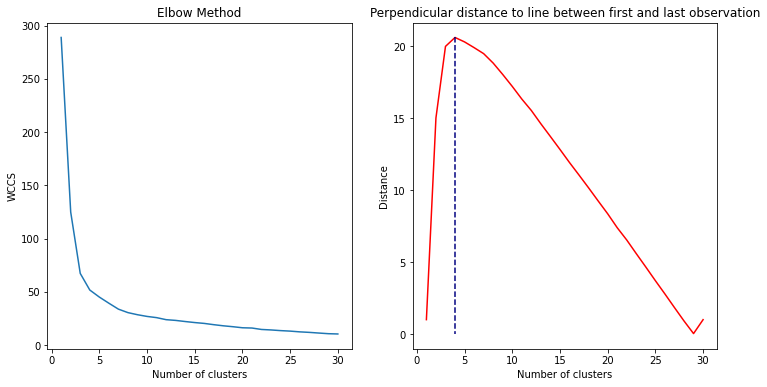

Nr of clusters = 4


In [61]:
X_trans = df_hrss[df_hrss.columns[:113]]
k = func.elbowMethod(X_trans, method='kmeans', n=30)
print('Nr of clusters = %s' % (k))

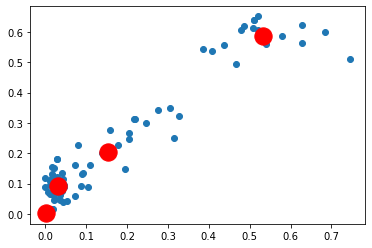

In [62]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_trans)
plt.scatter(X_trans.values[:,0], X_trans.values[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

df_hrss['cluster'] = kmeans.fit_predict(X_trans)

In [37]:
from bokeh.palettes import Spectral4
import importlib as imp

imp.reload(func)

#func.makeTSNE_Cluster(df_hrss.values, df_all['Category'], df_hrss['cluster'].astype(str), title='All', clusters=4, pal=Spectral8, seed=2)

<module 'DeepPhenotyping_functions' from 'C:\\Users\\levrex\\Desktop\\DeepPhenotypingHPO\\DeepPhenotyping_functions.py'>

In [114]:
from bokeh.palettes import Colorblind8
func.makeTSNE_Cluster2(df_hrss[df_hrss.columns[:113]].values,df_all['Id'],  df_hrss['cluster'].astype(str), df_all['Category'],
                      title='All', clusters=4, pal=[Colorblind8, Colorblind8], seed=2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.001s...
[t-SNE] Computed neighbors for 113 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 0.692538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.851517
[t-SNE] KL divergence after 800 iterations: 0.140663
KMeans(n_clusters=4, random_state=2)

TSNE figure saved under location: TSNE/Kmeans_phenoMap_tsne_All.html


In [50]:
func.makePCA(df_hrss[df_hrss.columns[:113]].values, df_all['Id'], df_all['Category'], title='All', pal=Spectral8)

Explained PCA:	PC1= 0.6146784274034158 	PC2= 0.2208000715467572
PCA figure saved under location: PCA/phenoMap_pca_All.html


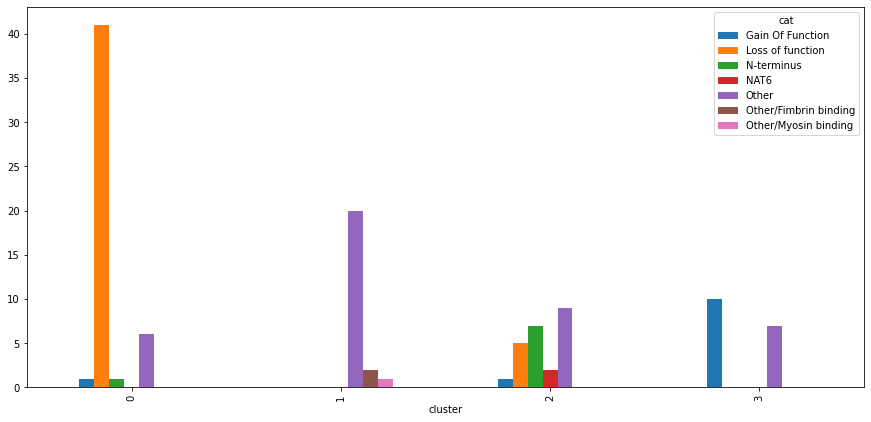

In [63]:
import matplotlib.pyplot as plt
#X = df_actg1.loc[:, cols].values # df_actg1.loc[:, cols].values # 
#X_trans = pca.fit_transform(X)


d = {'cat': df_all['Category'], 'cluster': df_hrss['cluster']}
df_bar = pd.DataFrame(data=d)
fig, ax = plt.subplots(figsize=(15,7))
df_bar.groupby(['cluster', 'cat']).size().unstack().plot(ax=ax, kind = 'bar') 


In [64]:
sub_df = pd.concat([df_all[['Category', 'Id', 'Origin']], df_hrss], axis=1)
sub_df = sub_df.sort_values('cluster')
sub_df = sub_df[list(sub_df.loc[:, ~sub_df.columns.isin(['cluster', 'Origin'])].columns)]
#func.makeDistanceHeatmap(sub_df, col_id='Id', col_label='Category', dist='HRSS', title='All')

In [98]:
sub_df = pd.concat([df_all[['Category', 'Id']], df_hrss[df_hrss.columns[:114]]], axis=1)
sub_df = sub_df.sort_values('cluster')
sub_df = sub_df[list(sub_df.loc[:, ~sub_df.columns.isin(['cluster'])].columns)]

C:\Users\levrex\Anaconda3\envs\my_env\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1440x1440 with 0 Axes>

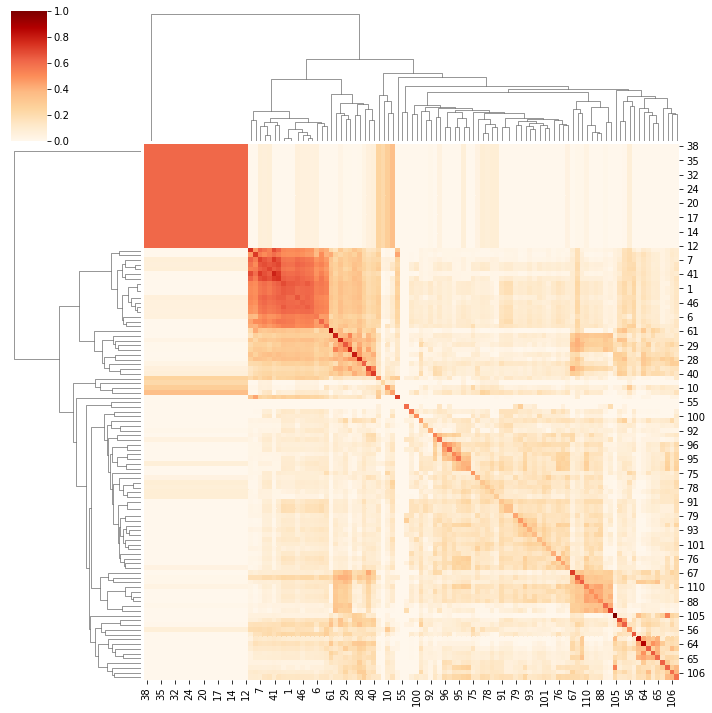

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.clustermap(
    df_hrss[df_hrss.columns[:113]],
    cmap='OrRd'
)

In [101]:
from bokehheat import heat

# generate test data
ls_sample = df_all['Id']
ls_variable = df_all['Id']


df_matrix = pd.DataFrame(df_hrss[df_hrss.columns[:113]].values)
df_matrix.index = ls_variable
df_matrix.columns = ls_sample
df_matrix.index.name = 'y'
df_matrix.columns.name = 'x'


In [102]:
#from bokeh.palettes import Spectral8
from bokeh.palettes import viridis
#col_list2= viridis(len(list(df_all['cluster'].unique())))

colors = ['Cyan','Green', 'Red','Yellow', 'Silver','Magenta','Orange', 'ForestGreen', 'Darkblue', 'Lime', 'Gray', 'Gold']
#color_list = [col_list2[list(df_all['cluster'].unique()).index(i)] for i in df_all['Origin']]
color_list2 = [colors[list(df_all['Category'].unique()).index(i)] for i in df_all['Category']]
color_list3 = [['Pink', 'Purple', 'Blue'][list(df_all['Origin'].unique()).index(i)] for i in df_all['Origin']]

len(df_all['Origin']), len(df_all['Category']), len(df_all['Id'])
#color_list

(113, 113, 113)

In [103]:
# generate some gene annotation
df_variable = pd.DataFrame({
    'y': ls_variable,
    'category': list(df_all['Category']),
    'origin' : list(df_all['Origin']),
    'category_color':color_list2,
    'origin_color': color_list3,
})
df_variable.index = df_variable.y

# generate some sample annotation
df_sample = pd.DataFrame({
    'x': ls_sample,
    'category': list(df_all['Category']),
    'origin' : list(df_all['Origin']),
    'category_color':color_list2,
    'origin_color': color_list3,
})
df_sample.index = df_sample.x


In [104]:
#t_yboole = (df_variable,['geneboole'],'Red','Maroon') # True, False
#t_ycat = (df_variable, ['cluster'], ['cluster_color'])
t_zcat = (df_variable, ['origin'], ['origin_color'])
#t_yquant = (df_variable, ['genereal'], [0], [k], [Colorblind8][::-1])
#t_xboole = (df_sample,['sampleboole'],'Red','Maroon') # True, False
t_xcat = (df_sample, ['category'], ['category_color'])
#t_xquant = (df_sample, ['age_year'], [0], [k], [YlGn8][::-1])
tt_boolecatquant = (t_xcat, t_zcat) # (t_ycat, t_yquant, t_xcat, t_xquant)

s_file = "clusterheatmap/heatmap_%s_All.html" % ('semanticHRSS')  # or "theclustermap.png"
o_clustermap, ls_xaxis, ls_yaxis = heat.clustermap(
    df_matrix = df_matrix,
    ls_color_palette = 'Magma256',
    r_low = 0,
    r_high = df_matrix.values.max(),
    s_z = "log2",
    tt_axis_annot = tt_boolecatquant,
    b_ydendo = True,
    b_xdendo = True,
    s_method= 'average',
    #s_metric= 'distance',
    #s_method= 'ward', #'average',
    s_metric= 'euclidean', #distance,
    b_optimal_ordering=True,
    #i_px = 64,
    #i_height = 12,
    #i_width = 12,
    #i_min_border_px = 128,
    s_filename=s_file,
    s_filetitel="the Clustermap",
)


ds_xcolor: {'Cyan': {'Gain Of Function'}, 'Green': {'Loss of function'}, 'Red': {'N-terminus'}, 'Yellow': {'Other'}, 'Silver': {'Other/Fimbrin binding'}, 'Magenta': {'Other/Myosin binding'}, 'Orange': {'NAT6'}, 'Pink': {'ACTG1'}, 'Purple': {'NAT6'}, 'Blue': {'ACTB'}}
ds_ycolor: {'Cyan': {'Gain Of Function'}, 'Green': {'Loss of function'}, 'Red': {'N-terminus'}, 'Yellow': {'Other'}, 'Silver': {'Other/Fimbrin binding'}, 'Magenta': {'Other/Myosin binding'}, 'Orange': {'NAT6'}, 'Pink': {'ACTG1'}, 'Purple': {'NAT6'}, 'Blue': {'ACTB'}}


## [Unused function] Import previous HPO translation

In [15]:
l_pat = []
hp_patients = []
with open('data/deepdata/actg_patpheno.csv', 'r') as f:
    for line in f:
        txt = line.split(',')
        txt[-1] = txt[-1].strip()
        l_pat.append(txt[0])
        hp_patients.append(txt[1:])
        #hp_patients.append()
        #f.write(str(pat) + ',' + ','.join(hp_patients[cnt]) + '\n')
        #cnt +=1

# CLUSTERING 2 : Individual Gene Occurrence

## Import data necessary to calculate gene occurrence

In [1]:
import pandas as pd
df_hpo = pd.read_table(r'hpo/util/annotation/phenotype_to_genes.txt', sep='\t|<tab>', engine='python') # phenotype_to_genes.txt
df_hpo.head()

,#Format: HPO-id,HPO label,entrez-gene-id,entrez-gene-symbol,Additional Info from G-D source,G-D source,disease-ID for link
0,HP:0000002,Abnormality of body height,26229,B3GAT3,-,mim2gene,OMIM:245600
1,HP:0000002,Abnormality of body height,2892,GRIA3,NaN,orphadata,ORPHA:364028
2,HP:0000002,Abnormality of body height,64374,SIL1,NaN,orphadata,ORPHA:559
3,HP:0000002,Abnormality of body height,10588,MTHFS,-,mim2gene,OMIM:618367
4,HP:0000002,Abnormality of body height,51633,OTUD6B,-,mim2gene,OMIM:617452


In [ ]:
import columns_linked_to_hpo
l_cols = df_all.columns

def binary_to_gene_occurrence(l_cols, col2hpo, df_hpo):
    """
    Calculate patient similarity with gene occurrence
    
    Input: 
    - l_cols = list with columns
    - col2hpo = translates columns to hpo
    - df_hpo = dataframe with hpo linked to associated genes
    
    
    Formula is as follows: 
    
    On Group level:
    nr of patients / nr of associated genes
    
    On individual level:
    1/ nr of associated genes
    
    """
    coef_list = []
    
    for val in l_cols:
        col = val.lower().strip()
        #assoc_genes = df_hpo[df_hpo['#Format: HPO-id']==hpo]['entrez-gene-id'].nunique()
        #coef_list.append(1/assoc_genes) # +0.00000001
        if col in col2hpo.keys():
            #print(col2hpo[col])
            
            if type(col2hpo[col]) == list:
                coef_list.extend([1/df_hpo[df_hpo['#Format: HPO-id']==hpo]['entrez-gene-id'].nunique() for hpo in col2hpo[col]])
            else :
                coef_list.append(1/df_hpo[df_hpo['#Format: HPO-id']==col2hpo[col]]['entrez-gene-id'].nunique())
            #break
    return coef_list

coef_list = binary_to_gene_occurrence(l_cols, col2hpo=columns_linked_to_hpo.column_to_hpo, df_hpo=df_hpo)
#print(coef_list)
#if (col in column_to_hpo.keys()) == False :

In [54]:
cnt = 0
df_occ = df_all.copy()
for column in df_all.columns[3:-1]:
    df_occ[column] = df_all[column]*coef_list[cnt]
    cnt += 1
df_occ.head()

,Category,Id,Protein,High frequency hearing loss,Short stature,microcephaly,hearing loss,ID,Developmental delay (Global),Motor Delay,...,Photosensitivity,Polyarthralgia,Hepatomegaly,Hypothyroidism,Leukocytosis,thrombocytopenia,Asthma,Strabismus,Growth hormone deficiency,Origin
0,Gain Of Function,LR04-298,p.Ser155Phe,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,ACTG1
1,Gain Of Function,LP98-096,p.Ser155Phe,0.0,0.142857,0.008772,0.0,0.000779,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,ACTG1
2,Gain Of Function,11-10857,p.Ser155Phe,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,ACTG1
3,Loss of function,LR11 334,Deletion 17q25.3,0.0,0.142857,0.000000,0.0,0.000000,0.004785,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015385,0.0,ACTG1
4,N-terminus,LR16?163,p.Asn12Asp,0.0,0.000000,0.000000,0.0,0.000779,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,ACTG1


In [175]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

cols = list(df_occ.loc[:, ~df_occ.columns.isin(['Category', 'Id', 'Protein', 'Origin'])].columns)

bool_dist = ['dice', 'hamming', 'jaccard',  'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'yule']
discrete_dist = ['braycurtis', 'canberra', 'chebyshev', 'cityblock','correlation', 'cosine','euclidean', 'jensenshannon', 'mahalanobis', 'minkowski', 'seuclidean', 'sqeuclidean',  'wminkowski', 'hamming']

distance = bool_dist[0]

df = df_occ.copy()
df = df.sample(frac=1)
pairwise = pd.DataFrame(
    squareform(pdist(df[cols], metric=distance)),
    columns = df['Id'],
    index = df['Id']
)

X_trans = pairwise.values 
#X_trans = df[cols]

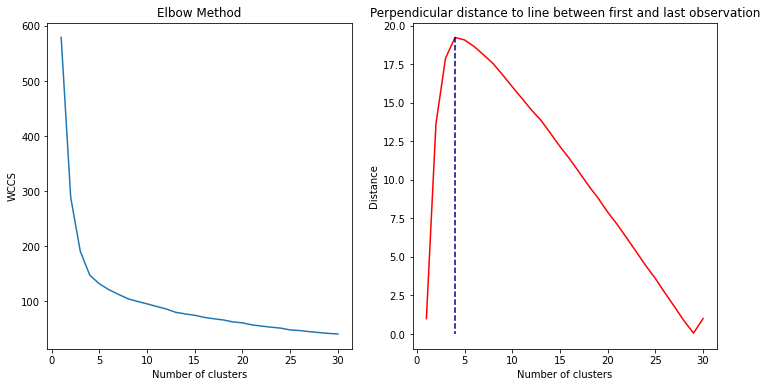

Nr of clusters = 4


In [176]:
k = func.elbowMethod(X_trans, method='kmeans', n=30)
print('Nr of clusters = %s' % (k))

In [177]:

#func.makeTSNE_Cluster(X_trans, df_occ['Id'], df_occ['Category'], title='All_GeneOccurrance_rogers', clusters=6, pal=Colorblind8)

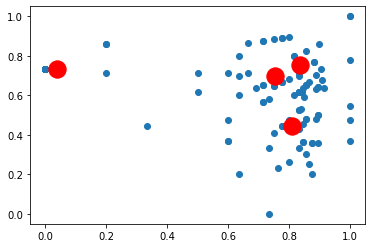

In [178]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_trans)
plt.scatter(X_trans[:,0], X_trans[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

df_occ['cluster'] = kmeans.fit_predict(X_trans)

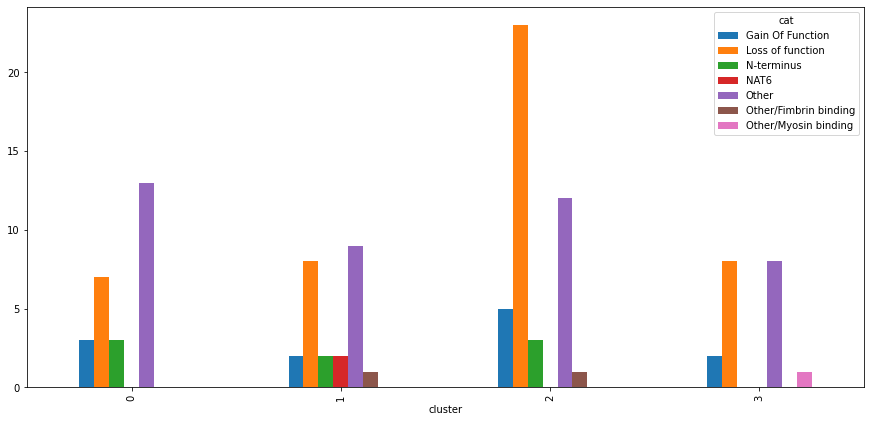

In [179]:
import matplotlib.pyplot as plt
#X = df_actg1.loc[:, cols].values # df_actg1.loc[:, cols].values # 
#X_trans = pca.fit_transform(X)


d = {'cat': df_occ['Category'], 'cluster': df_occ['cluster']}
df_bar = pd.DataFrame(data=d)
fig, ax = plt.subplots(figsize=(15,7))
df_bar.groupby(['cluster', 'cat']).size().unstack().plot(ax=ax, kind = 'bar') 

In [173]:
import importlib as imp

imp.reload(func)
func.makePCA2(X_trans,df_occ['Id'],  df_occ['cluster'].astype(str), df_occ['Category'],  df_occ['Origin'],
                      title='All_GeneOccurrance_rogers', clusters=k, pal=[Colorblind8, Colorblind8, Colorblind8], seed=2)

Explained PCA:	PC1= 0.9242048741274692 	PC2= 0.04813958741541355

PCA figure saved under location: PCA/phenoMap_pca_All_GeneOccurrance_rogers.html


In [161]:
func.makeTSNE_Cluster3(X_trans,df_occ['Id'],  df_occ['cluster'].astype(str), df_occ['Category'],  df_occ['Origin'],
                      title='All_GeneOccurrance_rogers', clusters=k, pal=[Colorblind8, Colorblind8, Colorblind8], seed=2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.000s...
[t-SNE] Computed neighbors for 113 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 0.685076
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.717361
[t-SNE] KL divergence after 1000 iterations: 0.194912
KMeans(n_clusters=5, random_state=2)

TSNE figure saved under location: TSNE/Kmeans_phenoMap_tsne_All_GeneOccurrance_rogers.html


# CLUSTER 3 - GROUPBASED

In [189]:
df_group

,HPOcode,HP:0000119,HP:0000079,HP:0010935,HP:0000077,HP:0012210,HP:0000107,HP:0100542,HP:0000085,HP:0000152,...,HP:0002012,HP:0001392,HP:0410042,HP:0025032,HP:0011458,HP:0011968,HP:0008872,HP:0040064,HP:0002817,HP:0001155
0,actbgain,0,0,0,0,0,0,0,0,"0,039154268",...,0,0,0,0,0,0,0,0,0,0
1,actbloss,"0,008458192","0,011393229","0,016385768","0,016778523","0,018541409","0,034722222","0,098425197","0,211864407","0,026429131",...,0,0,0,"0,02173913","0,026840491","0,045992116","0,09383378","0,009982886","0,00400641","0,004355401"
2,actbnterminus,0,0,0,0,0,0,0,0,"0,039154268",...,0,0,0,0,0,0,0,0,0,0
3,actbabs,0,0,0,0,0,0,0,0,"0,031323414",...,"0,019379845","0,022962113","0,027662517",0,0,0,0,"0,011409013","0,016025641","0,017421603"
4,actbother,0,0,0,0,0,0,0,0,"0,039154268",...,0,0,0,0,0,0,0,"0,005704507",0,0
5,actbtotal,"0,005126177","0,006904987","0,009930768","0,010168802","0,011237218","0,021043771","0,059651634","0,128402671","0,030848817",...,"0,00146817","0,001739554","0,002095645","0,013175231","0,016266964","0,027874009","0,056868958","0,007778873","0,003642191","0,003959455"
6,actg1gain,0,0,0,0,0,0,0,0,"0,026102845",...,0,0,0,0,0,0,0,0,0,0
7,actg1loss,0,0,0,0,0,0,0,0,"0,039154268",...,0,0,0,0,0,0,0,0,0,0
8,actg1nterminus,0,0,0,0,0,0,0,0,"0,039154268",...,0,0,0,"0,062111801","0,076687117","0,131406045","0,268096515",0,0,0
9,actg1other,0,0,0,0,0,0,0,0,"0,009212769",...,0,0,0,0,0,0,0,"0,001677796",0,0


In [193]:
df_group = pd.read_csv(r'data/deep_group/occurance_ratio_N6_and_ACTB_and_ACTG1.txt', sep='\t', header=0)
df_group = df_group.apply(lambda x: x.astype('str').str.replace(',','.'))
df_group.head()

,HPOcode,HP:0000119,HP:0000079,HP:0010935,HP:0000077,HP:0012210,HP:0000107,HP:0100542,HP:0000085,HP:0000152,...,HP:0002012,HP:0001392,HP:0410042,HP:0025032,HP:0011458,HP:0011968,HP:0008872,HP:0040064,HP:0002817,HP:0001155
0,actbgain,0,0,0,0,0,0,0,0,0.039154268,...,0,0,0,0,0,0,0,0,0,0
1,actbloss,0.008458192,0.011393229,0.016385768,0.016778523,0.018541409,0.034722222,0.098425197,0.211864407,0.026429131,...,0,0,0,0.02173913,0.026840491,0.045992116,0.09383378,0.009982886,0.00400641,0.004355401
2,actbnterminus,0,0,0,0,0,0,0,0,0.039154268,...,0,0,0,0,0,0,0,0,0,0
3,actbabs,0,0,0,0,0,0,0,0,0.031323414,...,0.019379845,0.022962113,0.027662517,0,0,0,0,0.011409013,0.016025641,0.017421603
4,actbother,0,0,0,0,0,0,0,0,0.039154268,...,0,0,0,0,0,0,0,0.005704507,0,0


In [256]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

#cols = list(df_group.loc[:, ~df_group.columns.isin(['Category', 'Id', 'Protein', 'Origin'])].columns)

bool_dist = ['dice', 'hamming', 'jaccard',  'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'yule']
discrete_dist = ['braycurtis', 'canberra', 'chebyshev', 'cityblock','correlation', 'cosine','euclidean', 'jensenshannon', 'mahalanobis', 'minkowski', 'seuclidean', 'sqeuclidean',  'wminkowski', 'hamming']

#distance = bool_dist[1]
distance = 'chebyshev' # discrete_dist[4]

df = df_group.copy()
df = df.sample(frac=1)
pairwise = pd.DataFrame(
    squareform(pdist(df_group[df_group.columns[1:]], metric=distance)),
    columns = df['HPOcode'],
    index = df['HPOcode']
)


X_trans = pairwise.values 
#X_trans=df_group[df_group.columns[1:]]

In [258]:
from bokeh.palettes import Paired12
import importlib as imp

imp.reload(func)

func.makePCA(X_trans, df_group['HPOcode'],  df_group['HPOcode'], title='_test_group', pal=Paired12, radius=10, seed=2)

Explained PCA:	PC1= 0.7918011319611168 	PC2= 0.15040913757798774
PCA figure saved under location: PCA/phenoMap_pca__test_group.html


In [249]:
#from bokeh.palettes import Paired12

#func.makePCA(X_trans, df_group['HPOcode'],  df_group['HPOcode'], title='_correlation_group', pal=Paired12, seed=2)

Explained PCA:	PC1= 0.38492155030314884 	PC2= 0.1681708295211341
PCA figure saved under location: PCA/phenoMap_pca__correlation_group.html
